In [ ]:
pip install keras_tuner

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json


Data loading

In [ ]:
try:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    print("Columns in df_train:", df_train.columns.tolist())
    print("Columns in df_test:", df_test.columns.tolist())
    print(f"Shape of df_train: {df_train.shape}")
    display(df_train.head())
    print(f"Shape of df_test: {df_test.shape}")
    display(df_test.head())
except FileNotFoundError:
    print("Error: One or both of the CSV files were not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Columns in df_train: ['id', 'sentiment', 'tweet']
Columns in df_test: ['id', 'sentiment', 'tweet']
Shape of df_train: (5600, 3)


,id,sentiment,tweet
0,29877,Negative,@user #recording is done! #videoshoot naman ð...
1,8125,Positive,'racism w/out races': classifying humans into ...
2,5389,Negative,ð competition ð follow &amp; to be in w...
3,13853,Negative,"on another note, me and damu are gonna go to a..."
4,17737,Negative,#nationalroseday ð¹ð¹ð¹ more &gt;&gt;


Shape of df_test: (1400, 3)


,id,sentiment,tweet
0,8735,Negative,#prideweek it's jelly donut time guuurrrlll
1,29016,Negative,save thousands $$ free search x logins x broke...
2,10143,Negative,!! free rpg day stuff has arrived! come and ...
3,16824,Negative,#ourlander you killed angus!!! nooooooo sweet ...
4,29434,Negative,travel. #travel #beautiful #ç¶ºéº #å°ç£ #ta...


Importing GloVe

In [ ]:
# GloVe embedding loading function
def load_glove(path="/content/glove.6B.200d.txt"):
    glove = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector
    return glove

In [ ]:
# Load GloVe vectors
glove = load_glove()
embedding_dim = 200

def get_vec(word):
    return glove.get(word, np.random.normal(scale=0.6, size=(embedding_dim,)))


Data preparation

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download required NLTK data (only needed once)
import nltk
# nltk.download('stopwords', quiet=True) # commented out as it's only needed once

def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub('\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub('<.*?>+', '', text)  # Remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub('\n', '', text)  # Remove newlines
    text = re.sub('\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'[^\x00-\x7F]+', '', text) # Remove non-ASCII characters
    text = re.sub('\s+', ' ', text)  # Remove extra whitespace

    # Stemming
    stemmer = PorterStemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    text = " ".join(stemmed_words)

    return text

# Handle missing values
df_train['tweet'] = df_train['tweet'].fillna('')
df_test['tweet'] = df_test['tweet'].fillna('')

# Clean the text
df_train['tweet'] = df_train['tweet'].apply(clean_text)
df_test['tweet'] = df_test['tweet'].apply(clean_text)

display(df_train.head())
display(df_test.head())

,id,sentiment,tweet
0,29877,Negative,user record is done videoshoot naman actor sin...
1,8125,Positive,racism wout race classifi human into race the ...
2,5389,Negative,competit follow amp to be in with a chanc end ...
3,13853,Negative,on anoth note me and damu are gonna go to a co...
4,17737,Negative,nationalroseday more gtgt


,id,sentiment,tweet
0,8735,Negative,prideweek it jelli donut time guuurrrlll
1,29016,Negative,save thousand free search x login x broker act...
2,10143,Negative,free rpg day stuff ha arriv come and see us to...
3,16824,Negative,ourland you kill angu nooooooo sweet loveabl a...
4,29434,Negative,travel travel beauti taiwan taitung funni love


Data exploration

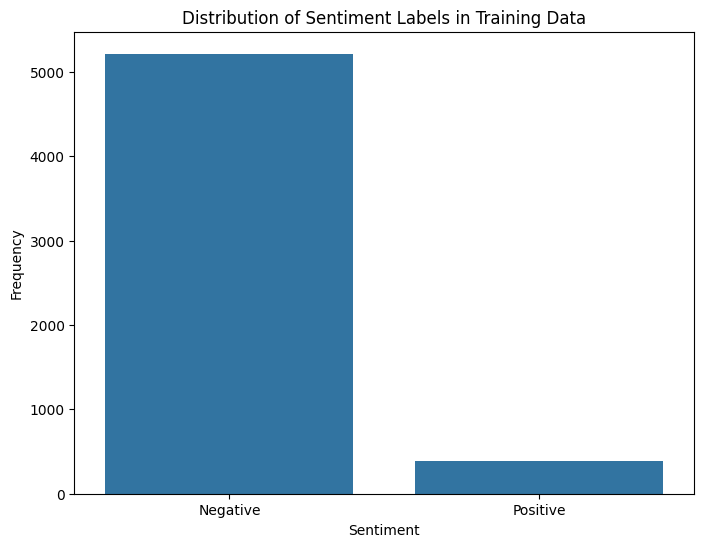

Descriptive Statistics for Tweet Length (Training Data):
count    5600.000000
mean       12.467321
std         5.426250
min         1.000000
25%         8.000000
50%        12.000000
75%        16.000000
max        29.000000
Name: tweet_length, dtype: float64

Descriptive Statistics for Tweet Length (Test Data):
count    1400.000000
mean       12.351429
std         5.351083
min         2.000000
25%         8.000000
50%        12.000000
75%        16.000000
max        29.000000
Name: tweet_length, dtype: float64


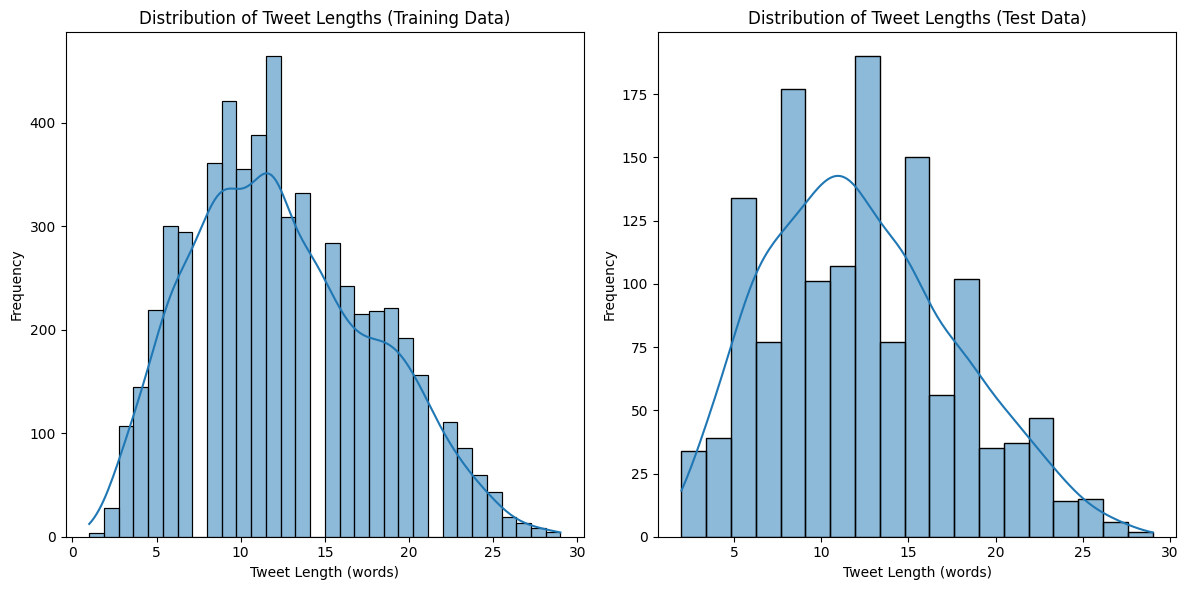

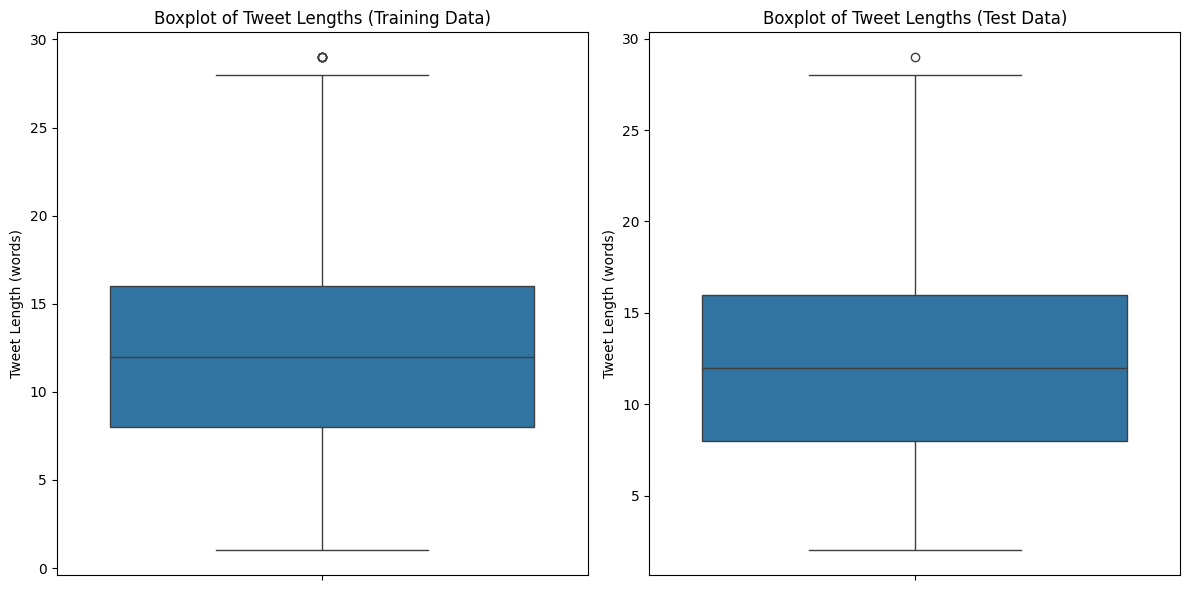

Observations:
  - There is a significant class imbalance in the training dataset.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sentiment Label Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_train)
plt.title('Distribution of Sentiment Labels in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

# 2. Review Length Analysis
df_train['tweet_length'] = df_train['tweet'].apply(lambda x: len(x.split()))
df_test['tweet_length'] = df_test['tweet'].apply(lambda x: len(x.split()))

print("Descriptive Statistics for Tweet Length (Training Data):")
print(df_train['tweet_length'].describe())
print("\nDescriptive Statistics for Tweet Length (Test Data):")
print(df_test['tweet_length'].describe())


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_train['tweet_length'], kde=True)
plt.title('Distribution of Tweet Lengths (Training Data)')
plt.xlabel('Tweet Length (words)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_test['tweet_length'], kde=True)
plt.title('Distribution of Tweet Lengths (Test Data)')
plt.xlabel('Tweet Length (words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_train['tweet_length'])
plt.title('Boxplot of Tweet Lengths (Training Data)')
plt.ylabel('Tweet Length (words)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_test['tweet_length'])
plt.title('Boxplot of Tweet Lengths (Test Data)')
plt.ylabel('Tweet Length (words)')

plt.tight_layout()
plt.show()


# 4. Observations (printed to the console)
print("Observations:")
if df_train['sentiment'].value_counts().max() / len(df_train) > 0.8:
    print("  - There is a significant class imbalance in the training dataset.")
if df_train['tweet_length'].std() > 10:
    print("  - There's a considerable variation in tweet lengths in training dataset.")
if df_test['tweet_length'].std() > 10:
    print("  - There's a considerable variation in tweet lengths in test dataset.")


Feature engineering

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>') # Limit vocabulary size
tokenizer.fit_on_texts(df_train['tweet'])

# Convert text to sequences
df_train['tokenized_tweet'] = tokenizer.texts_to_sequences(df_train['tweet'])
df_test['tokenized_tweet'] = tokenizer.texts_to_sequences(df_test['tweet'])


# 2. Padding
max_length = max(df_train['tweet_length'].max(), df_test['tweet_length'].max())
df_train['padded_tweet'] = pad_sequences(df_train['tokenized_tweet'], maxlen=max_length, padding='pre', truncating='post').tolist()
df_test['padded_tweet'] = pad_sequences(df_test['tokenized_tweet'], maxlen=max_length, padding='pre', truncating='post').tolist()


# 3. Target Encoding
sentiment_mapping = {'Negative': 0, 'Positive': 1}
df_train['encoded_sentiment'] = df_train['sentiment'].map(sentiment_mapping)
df_test['encoded_sentiment'] = df_test['sentiment'].map(sentiment_mapping)

# Display to verify
display(df_train.head())
display(df_test.head())

,id,sentiment,tweet,tweet_length,tokenized_tweet,padded_tweet,encoded_sentiment
0,29877,Negative,user record is done videoshoot naman actor sin...,13,"[2, 1251, 12, 438, 4248, 4249, 816, 1115, 4250...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,8125,Positive,racism wout race classifi human into race the ...,15,"[660, 4252, 247, 4253, 420, 292, 247, 3, 1636,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 660...",1
2,5389,Negative,competit follow amp to be in with a chanc end ...,15,"[1417, 104, 30, 4, 16, 11, 19, 5, 1252, 177, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 141...",0
3,13853,Negative,on anoth note me and damu are gonna go to a co...,18,"[17, 185, 1116, 28, 8, 4255, 23, 320, 52, 4, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 185, 111...",0
4,17737,Negative,nationalroseday more gtgt,3,"[4256, 83, 2650]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


,id,sentiment,tweet,tweet_length,tokenized_tweet,padded_tweet,encoded_sentiment
0,8735,Negative,prideweek it jelli donut time guuurrrlll,6,"[1, 13, 1, 6886, 33, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,29016,Negative,save thousand free search x login x broker act...,11,"[511, 1641, 182, 878, 489, 1041, 489, 932, 816...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,10143,Negative,free rpg day stuff ha arriv come and see us to...,15,"[182, 1, 18, 669, 105, 429, 97, 8, 68, 106, 13...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182...",0
3,16824,Negative,ourland you kill angu nooooooo sweet loveabl a...,10,"[1, 7, 238, 1, 1, 612, 1, 1, 1, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,29434,Negative,travel travel beauti taiwan taitung funni love,7,"[264, 264, 79, 1784, 1, 291, 15]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


generating embedding matrix

In [ ]:
# Get the word index from your tokenizer
word_index = tokenizer.word_index

# Define the maximum number of words in your vocabulary (you set it to 10000)
max_words = 10000

# Create the embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
words_found = 0

for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = get_vec(word)
    embedding_matrix[i] = embedding_vector
    words_found += 1

print(f"Found GloVe embeddings for {words_found} words out of {min(len(word_index), max_words)} in vocabulary")

Found GloVe embeddings for 9995 words out of 9995 in vocabulary


Train test split

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare features (X) and target variable (y)
X = np.array(df_train['padded_tweet'].tolist())
y = np.array(df_train['encoded_sentiment'].tolist())

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (4480, 29)
X_val shape: (1120, 29)
y_train shape: (4480,)
y_val shape: (1120,)


Model

In [ ]:
# Define model building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Use pre-trained GloVe embeddings
    model.add(Embedding(
        input_dim=max_words,
        output_dim=200,   # Fixed at 200 for GloVe
        weights=[embedding_matrix],
        trainable=False,  # Freeze the embeddings
        input_length=max_length
    ))

    model.add(SimpleRNN(
        units=25,
        dropout=hp.Choice('dropout', [0.2, 0.3, 0.4]),
        recurrent_dropout=hp.Choice('recurrent_dropout', [0.2, 0.3, 0.4])
    ))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [0.001, 0.0005, 0.0001])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

Pipeline for hyperparameter tuning

In [ ]:
# Set up the tuner - now without embedding_dim as a hyperparameter
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='rnn_glove_model'
)

# Define early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run the search
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[stop_early]
)

Trial 30 Complete [00h 00m 31s]
val_accuracy: 0.9357143044471741

Best val_accuracy So Far: 0.9410714507102966
Total elapsed time: 00h 07m 41s


Best hyperparameters and model

In [ ]:
# Get the best hyperparameters and build the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Print the best hyperparameters
print("Embedding dimension (GloVe):", embedding_dim)  # Fixed value
print("Best dropout rate:", best_hps.get('dropout'))
print("Best recurrent dropout rate:", best_hps.get('recurrent_dropout'))
print("Best learning rate:", best_hps.get('lr'))

# Train the model with the best hyperparameters
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[stop_early]
)

Embedding dimension (GloVe): 200
Best dropout rate: 0.2
Best recurrent dropout rate: 0.2
Best learning rate: 0.001
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7019 - loss: 0.5663 - val_accuracy: 0.9286 - val_loss: 0.2557
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9343 - loss: 0.2373 - val_accuracy: 0.9321 - val_loss: 0.2417
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9262 - loss: 0.2595 - val_accuracy: 0.9321 - val_loss: 0.2387
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9308 - loss: 0.2347 - val_accuracy: 0.9321 - val_loss: 0.2375
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9389 - loss: 0.2177 - val_accuracy: 0.9357 - val_loss: 0.2295
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9389 - loss: 0.2134 - val_accuracy: 0.9357 - val_loss: 0.2305
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9353 - loss: 0.2066 - val_accuracy: 0.9357 - val_l

Model Evaluation

In [ ]:
# Prepare features (X_test) and target variable (y_test) from df_test
X_test = np.array(df_test['padded_tweet'].tolist())
y_test = np.array(df_test['encoded_sentiment'].tolist())

# Now you can evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9293 - loss: 0.2478
Test accuracy: 0.9314


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = df_test['encoded_sentiment']
y_pred = best_model.predict(X_test)
y_pred = np.round(y_pred) # round the predictions


# Calculate metrics
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
F1 Score: 0.9125831696151494
Precision: 0.9193328374887266
Recall: 0.9314285714285714


In [ ]:
tuner.results_summary()

Results summary
Results in hyperparameter_tuning/rnn_glove_model
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0024 summary
Hyperparameters:
dropout: 0.2
recurrent_dropout: 0.2
lr: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.9410714507102966

Trial 0026 summary
Hyperparameters:
dropout: 0.2
recurrent_dropout: 0.3
lr: 0.001
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9401785731315613

Trial 0016 summary
Hyperparameters:
dropout: 0.2
recurrent_dropout: 0.2
lr: 0.0005
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 0.9392856955528259

Trial 0025 summary
Hyperparameters:
dropout: 0.3
recurrent_dropout: 0.3
lr: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.9392856955528259

Trial 0017 summary
Hyperparameters:
dropout: 0.3
recurrent_dropout: 0.2
lr:

Saving insights

In [ ]:
# Hyperparameter analysis code
# Get all trials (the correct way)
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))
trial_results = []

for trial in trials:
    # Extract trial info
    trial_data = {
        'trial_id': trial.trial_id,
        'score': trial.score,  # This is the metric you optimized for (val_accuracy)
        'best_epoch': trial.best_step
    }

    # Add all hyperparameters (only the ones actually used in your model)
    for hp_name, hp_value in trial.hyperparameters.values.items():
        if hp_name in ['dropout', 'recurrent_dropout', 'lr']:  # Removed embedding_dim
            trial_data[hp_name] = hp_value

    # Add the fixed embedding dim value
    trial_data['embedding_dim'] = 200  # Fixed value

    # Add metrics history
    if hasattr(trial, 'metrics') and trial.metrics:
        for metric_name in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
            if metric_name in trial.metrics.metrics:
                metric_history = trial.metrics.get_history(metric_name)
                if metric_history:
                    trial_data[f'final_{metric_name}'] = metric_history[-1]

    trial_results.append(trial_data)

# Convert to DataFrame and save to CSV for easy analysis
results_df = pd.DataFrame(trial_results)
results_df = results_df.sort_values('score', ascending=False)  # Sort by performance
results_df.to_csv('hyperparameter_trials_results.csv', index=False)

# Save additional detailed information about the best trials
best_trials = tuner.oracle.get_best_trials(num_trials=min(5, len(tuner.oracle.trials)))  # Adjust number as needed
detailed_results = []

for i, trial in enumerate(best_trials):
    # Extract all available information
    detailed_data = {
        'rank': i+1,
        'trial_id': trial.trial_id,
        'score': trial.score,
        'hyperparameters': {
            k: v for k, v in trial.hyperparameters.values.items()
            if k in ['dropout', 'recurrent_dropout', 'lr']  # Removed embedding_dim
        },
        'embedding_dim': 200,  # Add the fixed embedding_dim value
        'rnn_units': 25  # Add the fixed RNN units value
    }

    # Add metrics history if available
    if hasattr(trial, 'metrics') and trial.metrics:
        detailed_data['metrics_history'] = {
            metric: trial.metrics.get_history(metric)
            for metric in ['loss', 'accuracy', 'val_loss', 'val_accuracy']
            if metric in trial.metrics.metrics
        }

    detailed_results.append(detailed_data)

# Save as JSON for detailed inspection
with open('best_trials_detailed.json', 'w') as f:
    json.dump(detailed_results, f, indent=2, default=str)  # default=str handles non-serializable objects

# Create a simple summary of hyperparameter effects - removed embedding_dim
print("Summary of hyperparameter effects:")
print("Note: embedding_dim is fixed at 200 with GloVe")
for param in ['dropout', 'recurrent_dropout', 'lr']:  # Removed embedding_dim
    if param in results_df.columns:
        param_effect = results_df.groupby(param)['score'].agg(['mean', 'std', 'count'])
        print(f"\n{param} effect on performance:")
        print(param_effect)

# Create visualization directory
os.makedirs('hyperparameter_analysis', exist_ok=True)

# Visualize the effect of each hyperparameter (except embedding_dim) with better y-axis scaling
for param in ['dropout', 'recurrent_dropout', 'lr']:  # Removed embedding_dim
    if param in results_df.columns:
        plt.figure(figsize=(10, 6))

        # Create boxplot
        ax = sns.boxplot(x=param, y='score', data=results_df)

        # Set y-axis range to start from 0.5 (or adjust based on your data)
        y_min = max(0.5, results_df['score'].min() - 0.05)  # Dynamic lower bound with minimum of 0.5
        y_max = min(1.0, results_df['score'].max() + 0.05)  # Dynamic upper bound with maximum of 1.0
        plt.ylim(y_min, y_max)

        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.title(f'Effect of {param} on model performance\n(RNN units=25, GloVe embedding_dim=200)')
        plt.ylabel('Validation Accuracy')
        plt.xlabel(param.replace('_', ' ').title())  # Better formatting for x-axis label

        # Add mean markers
        means = results_df.groupby(param)['score'].mean()
        for i, mean_val in enumerate(means):
            plt.plot(i, mean_val, 'o', color='red', markersize=8)
            plt.annotate(f'{mean_val:.4f}', (i, mean_val),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center')

        plt.tight_layout()
        plt.savefig(f'hyperparameter_analysis/{param}_effect.png', dpi=300, bbox_inches='tight')
        plt.close()

# Create hyperparameter correlation heatmap if we have enough numeric columns
plt.figure(figsize=(12, 10))
corr_columns = [col for col in results_df.columns if col not in ['trial_id']]
corr_df = results_df[corr_columns].copy()
corr_df = corr_df.select_dtypes(include=[np.number])  # Only numeric columns
if corr_df.shape[1] > 1:  # Only create heatmap if we have multiple numeric columns
    sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between hyperparameters and performance\n(RNN units=25, GloVe embedding_dim=200)')
    plt.tight_layout()
    plt.savefig('hyperparameter_analysis/correlation_heatmap.png', dpi=300)
plt.close()

Summary of hyperparameter effects:
Note: embedding_dim is fixed at 200 with GloVe

dropout effect on performance:
             mean       std  count
dropout                           
0.2      0.927158  0.019444     12
0.3      0.928571  0.015215     11
0.4      0.923980  0.022437      7

recurrent_dropout effect on performance:
                       mean       std  count
recurrent_dropout                           
0.2                0.931044  0.013727     13
0.3                0.928671  0.017101      9
0.4                0.918304  0.024326      8

lr effect on performance:
            mean       std  count
lr                               
0.0001  0.906808  0.026452      8
0.0005  0.932873  0.002456     11
0.0010  0.935633  0.004081     11
